# Getting Started with Permuted MNIST Environment

## Objective

The goal of this tutorial is to:
- Learn how to use the PermutedMNIST environment for meta-learning experiments
- Train and evaluate different agents on permuted MNIST tasks
- Compare the performance of a **Random baseline** vs a **Linear classifier**
- Achieve training and prediction in **less than 1 minute** per task

## What is Permuted MNIST?

Permuted MNIST is a meta-learning benchmark where:
- Each task uses the same MNIST dataset
- For each task, pixels are randomly permuted (shuffled) in a consistent way
- Labels are also randomly permuted (e.g., all 3s might become 7s)
- The agent must quickly adapt to each new permutation

## 1. Setup and Imports

In [1]:
!git clone https://github.com/ml-arena/permuted_mnist.git



Cloning into 'permuted_mnist'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 194 (delta 77), reused 163 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (194/194), 12.62 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
import sys
sys.path.append('/content/permuted_mnist')



In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from permuted_mnist.agent.random.agent import Agent as RandomAgent
from permuted_mnist.agent.linear.agent import Agent as LinearAgent
from permuted_mnist.agent.torch_mlp.agent import Agent as TorchMLP

print("✓ Imports successful")

✓ Imports successful


## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [4]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [5]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

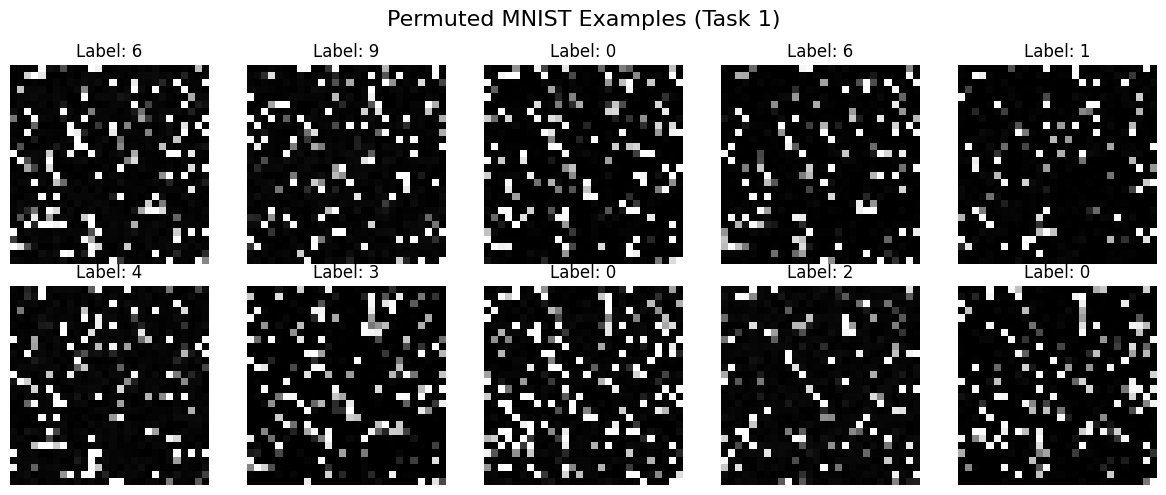

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [6]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

## 5. Baseline: Random Agent

First, let's establish a baseline with an agent that makes random predictions:

In [7]:
# Reset environment for fresh start
env.reset()
env.set_seed(42)

# Create random agent
random_agent = RandomAgent(output_dim=10, seed=42)

# Track performance
random_accuracies = []
random_times = []

print("Evaluating Random Agent (Baseline)")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    start_time = time.time()

    # "Train" (random agent doesn't actually learn)
    random_agent.train(task['X_train'], task['y_train'])

    # Make predictions
    predictions = random_agent.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    random_accuracies.append(accuracy)
    random_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1

print(f"\nRandom Agent Summary:")
print(f"  Mean accuracy: {np.mean(random_accuracies):.2%} ± {np.std(random_accuracies):.2%}")
print(f"  Total time: {np.sum(random_times):.2f}s")

Evaluating Random Agent (Baseline)
Task 1: Accuracy = 9.96%, Time = 0.0003s
Task 2: Accuracy = 9.70%, Time = 0.0003s
Task 3: Accuracy = 10.41%, Time = 0.0003s
Task 4: Accuracy = 10.02%, Time = 0.0003s
Task 5: Accuracy = 10.23%, Time = 0.0003s
Task 6: Accuracy = 9.94%, Time = 0.0003s
Task 7: Accuracy = 10.29%, Time = 0.0003s
Task 8: Accuracy = 10.27%, Time = 0.0002s
Task 9: Accuracy = 9.93%, Time = 0.0003s
Task 10: Accuracy = 10.09%, Time = 0.0003s

Random Agent Summary:
  Mean accuracy: 10.08% ± 0.20%
  Total time: 0.00s


## 6. Linear Agent

Now let's train a simple linear classifier that actually learns from the data:

In [ ]:
# Reset environment
env.reset()
env.set_seed(42)

# Create linear agent
linear_agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=0.01)

# Track performance
linear_accuracies = []
linear_times = []

print("Evaluating Linear Agent")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    # Reset agent for new task
    linear_agent.reset()

    start_time = time.time()

    # Train the linear model
    linear_agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)

    # Make predictions
    predictions = linear_agent.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    linear_accuracies.append(accuracy)
    linear_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.2f}s")
    task_num += 1

print(f"\nLinear Agent Summary:")
print(f"  Mean accuracy: {np.mean(linear_accuracies):.2%} ± {np.std(linear_accuracies):.2%}")
print(f"  Total time: {np.sum(linear_times):.2f}s")

Evaluating Linear Agent
Task 1: Accuracy = 90.98%, Time = 2.81s
Task 2: Accuracy = 90.84%, Time = 2.55s
Task 3: Accuracy = 90.91%, Time = 2.54s
Task 4: Accuracy = 90.81%, Time = 2.37s
Task 5: Accuracy = 90.90%, Time = 2.72s
Task 6: Accuracy = 90.90%, Time = 2.49s
Task 7: Accuracy = 90.81%, Time = 2.41s
Task 8: Accuracy = 90.76%, Time = 2.38s
Task 9: Accuracy = 90.83%, Time = 2.76s
Task 10: Accuracy = 90.85%, Time = 2.41s

Linear Agent Summary:
  Mean accuracy: 90.86% ± 0.06%
  Total time: 25.44s


Build a deep model capable of truly learning nonlinear structures.
Compared with the previous linear classifier, this model:

Contains at least one hidden layer (for example: 784 → 256 → 10);

Uses activation functions (such as ReLU or Tanh) to introduce nonlinearity;

Is retrained and evaluated on each permuted task independently.

👇it takes too long to achive 98%. So i stopped it in the middle.

In [ ]:
# Reset environment
env.reset()
env.set_seed(42)

# Create linear agent
torchmlp = TorchMLP(output_dim=10,seed=42)

# Track performance
torchmlp_accuracies = []
torchmlp_times = []

print("Evaluating TorchMLP Agent")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    # Reset agent for new task
    torchmlp.reset()

    start_time = time.time()

    # Train the linear model
    torchmlp.train(task['X_train'], task['y_train'])

    # Make predictions
    predictions = torchmlp.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    torchmlp_accuracies.append(accuracy)
    torchmlp_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(torchmlp_accuracies):.2%} ± {np.std(torchmlp_accuracies):.2%}")
print(f"  Total time: {np.sum(torchmlp_times):.2f}s")

Evaluating TorchMLP Agent
epoch 0: 0.9623%
epoch 1: 0.9715%
epoch 2: 0.9735%
epoch 3: 0.9763%
epoch 4: 0.9776%
epoch 5: 0.9781%
epoch 6: 0.9812%
epoch 7: 0.9777%
epoch 8: 0.9816%
epoch 9: 0.9832%
Task 1: Accuracy = 98.02%, Time = 155.17s
epoch 0: 0.9636%
epoch 1: 0.9732%
epoch 2: 0.9742%
epoch 3: 0.9779%
epoch 4: 0.9813%
epoch 5: 0.9793%
epoch 6: 0.9802%
epoch 7: 0.9817%
epoch 8: 0.9801%
epoch 9: 0.9817%
Task 2: Accuracy = 98.18%, Time = 150.47s
epoch 0: 0.9665%
epoch 1: 0.9719%
epoch 2: 0.9732%
epoch 3: 0.9742%
epoch 4: 0.9782%
epoch 5: 0.9769%
epoch 6: 0.9764%
epoch 7: 0.9810%
epoch 8: 0.9779%
epoch 9: 0.9811%
Task 3: Accuracy = 98.05%, Time = 151.65s
epoch 0: 0.9617%
epoch 1: 0.9732%
epoch 2: 0.9751%
epoch 3: 0.9774%
epoch 4: 0.9782%
epoch 5: 0.9773%
epoch 6: 0.9821%
epoch 7: 0.9829%
epoch 8: 0.9834%
epoch 9: 0.9806%
Task 4: Accuracy = 98.07%, Time = 147.96s
epoch 0: 0.9576%
epoch 1: 0.9756%
epoch 2: 0.9762%
epoch 3: 0.9770%
epoch 4: 0.9807%
epoch 5: 0.9776%
epoch 6: 0.9808%
epoch 7

KeyboardInterrupt: 

Because the above version took so long to generate, so it occured me to try early stopping.

In [ ]:
# ===== TorchMLP (speed profile with early stopping) =====
import time, math, numpy as np
import torch, torch.nn as nn, torch.optim as optim

try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _flatten_np(X):
    return X.reshape(X.shape[0], -1).astype(np.float32, copy=False)

def _labels_1d(y):
    y = np.asarray(y)
    return y.reshape(-1).astype(np.int64, copy=False)

@torch.no_grad()
def _scalar_norm_fit(X):
    m = float(X.mean()); s = float(X.std())
    if s < 1e-6: s = 1.0
    return m, s

class _SpeedMLP(nn.Module):
    def __init__(self, in_dim=784, h1=512, h2=256, out_dim=10, p=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.ReLU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x): return self.net(x)

class TorchMLP:
    def __init__(self, output_dim=10, seed=42,
                 time_budget=5.5, subsample_n=20000,
                 val_ratio=0.1, batch_size=2048,
                 lr=3e-3, weight_decay=1e-4,
                 patience=2, min_delta=0.001, min_train_seconds=2.5):
        self.output_dim = output_dim
        self.seed = seed
        self.time_budget = float(time_budget)
        self.subsample_n = int(subsample_n)
        self.val_ratio = float(val_ratio)
        self.batch_size = int(batch_size)
        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.min_train_seconds = float(min_train_seconds)
        self.device = torch.device("cpu")
        self.model = None
        self.mean_, self.std_ = 0.0, 1.0
        self.reset()

    def reset(self):
        np.random.seed(self.seed); torch.manual_seed(self.seed)
        self.model = _SpeedMLP(out_dim=self.output_dim).to(self.device)
        self.mean_, self.std_ = 0.0, 1.0

    def _make_loader(self, X, y, bs, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        t0 = time.time()
        Xf = _flatten_np(X_train)
        y = _labels_1d(y_train)
        N = Xf.shape[0]
        ss = min(self.subsample_n, N)
        idx = np.random.default_rng(self.seed).choice(N, ss, replace=False)
        Xs = torch.from_numpy(Xf[idx]).float().to(self.device)
        ys = torch.from_numpy(y[idx]).to(self.device)

        n_val = max(1000, int(len(Xs) * 0.1))
        n_tr  = len(Xs) - n_val
        X_tr, X_val = Xs[:n_tr], Xs[n_tr:]
        y_tr, y_val = ys[:n_tr], ys[n_tr:]

        self.mean_, self.std_ = _scalar_norm_fit(X_tr)
        X_tr = (X_tr - self.mean_) / self.std_
        X_val = (X_val - self.mean_) / self.std_

        opt = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()
        loader = self._make_loader(X_tr, y_tr, self.batch_size, shuffle=True)

        best_acc, no_improve = 0.0, 0
        self.model.train()
        while True:
            for xb, yb in loader:
                if time.time() - t0 > self.time_budget: break
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward(); opt.step()
            if time.time() - t0 > self.time_budget: break

            # 验证
            with torch.no_grad():
                self.model.eval()
                bs_eval = 8192
                correct, total = 0, 0
                for i in range(0, X_val.shape[0], bs_eval):
                    logits = self.model(X_val[i:i+bs_eval])
                    pred = logits.argmax(dim=1)
                    correct += (pred == y_val[i:i+bs_eval]).sum().item()
                    total   += min(bs_eval, X_val.shape[0]-i)
                val_acc = correct / max(1, total)
                self.model.train()

            if val_acc > best_acc + self.min_delta:
                best_acc = val_acc
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= self.patience and (time.time()-t0) >= self.min_train_seconds:
                break

    @torch.no_grad()
    def predict(self, X_test):
        X = torch.from_numpy(_flatten_np(X_test)).float().to(self.device)
        X = (X - self.mean_) / self.std_
        self.model.eval()
        bs = 8192
        out = []
        for i in range(0, X.shape[0], bs):
            out.append(torch.argmax(self.model(X[i:i+bs]), dim=1).cpu().numpy())
        return np.concatenate(out, axis=0)
# Reset environment
env.reset()
env.set_seed(42)

# Create agent
torchmlp = TorchMLP(output_dim=10, seed=42)

# Track performance
accs, times = [], []

print("Evaluating TorchMLP Agent")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    torchmlp.reset()
    start = time.time()
    torchmlp.train(task['X_train'], task['y_train'])
    preds = torchmlp.predict(task['X_test'])
    elapsed = time.time() - start
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent
Task 1: Accuracy = 94.90%, Time = 5.73s
Task 2: Accuracy = 94.73%, Time = 5.72s
Task 3: Accuracy = 94.71%, Time = 5.94s
Task 4: Accuracy = 94.86%, Time = 5.73s
Task 5: Accuracy = 95.21%, Time = 5.80s
Task 6: Accuracy = 95.36%, Time = 5.79s
Task 7: Accuracy = 94.70%, Time = 5.83s
Task 8: Accuracy = 94.80%, Time = 5.73s
Task 9: Accuracy = 95.03%, Time = 5.72s
Task 10: Accuracy = 94.72%, Time = 5.76s

TorchMLP Agent Summary:
  Mean accuracy: 94.90% ± 0.22%
  Total time: 57.74s


#TorchMLP with BN ( i tried some other staff as well but this one worked the best so i kept it )

In [ ]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    # 如果数据是 0-255 则缩放到 0-1；否则保持原样（避免重复除法）
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        # 轻量初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm (参数按你的要求)：
      - 两个隐藏层各 100 单元，ReLU + BatchNorm
      - Adam(lr=1e-3)，batch_size=128，epochs=3
      - 验证集比例 0.2（用于监控）
      - 输入归一化到 [0,1]
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        # 固定随机种子
        np.random.seed(seed); torch.manual_seed(seed)

        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        # 数据 -> Tensor
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        # 划分验证集
        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

            # 可选：最后一轮打印一次验证准确率（不影响速度/结果）
            # if ep == self.epochs - 1:
            #     self.model.eval()
            #     with torch.no_grad():
            #         pred = self.model(X_val).argmax(dim=1)
            #         acc = (pred == y_val).float().mean().item()
            #     self.model.train()
            #     print(f"[val] epoch {ep}: acc={acc:.4f}")

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)
# ===== Evaluate TorchMLP-BN (fixed) =====
import time, numpy as np

env.reset()
env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []   # ← 这里要两个空列表

print("Evaluating TorchMLP Agent (BN, 2x100)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 2x100)
Task 1: Accuracy = 97.26%, Time = 6.70s
Task 2: Accuracy = 97.25%, Time = 6.09s
Task 3: Accuracy = 97.25%, Time = 5.44s
Task 4: Accuracy = 97.19%, Time = 5.62s
Task 5: Accuracy = 96.93%, Time = 6.29s
Task 6: Accuracy = 97.50%, Time = 5.83s
Task 7: Accuracy = 97.10%, Time = 5.33s
Task 8: Accuracy = 97.35%, Time = 5.84s
Task 9: Accuracy = 97.31%, Time = 6.16s
Task 10: Accuracy = 97.15%, Time = 5.68s

TorchMLP Agent Summary:
  Mean accuracy: 97.23% ± 0.15%
  Total time: 58.98s


#TorchMLP　with BN and L２ normalization as FE


In [ ]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-BN (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 2x100) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 2x100) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.41%, Time = 5.68s
Task 2: Accuracy = 97.34%, Time = 5.50s
Task 3: Accuracy = 97.35%, Time = 5.85s
Task 4: Accuracy = 97.46%, Time = 7.38s
Task 5: Accuracy = 97.15%, Time = 6.18s
Task 6: Accuracy = 97.37%, Time = 5.32s
Task 7: Accuracy = 97.15%, Time = 5.56s
Task 8: Accuracy = 97.27%, Time = 6.30s
Task 9: Accuracy = 97.33%, Time = 6.26s
Task 10: Accuracy = 97.33%, Time = 5.45s

TorchMLP Agent Summary:
  Mean accuracy: 97.32% ± 0.10%
  Total time: 59.47s


#TorchMLP BN ＋ L2 normalization + hidden(256,128) wide first and then narrow

In [ ]:
# ===== TorchMLP-BN (256→128 pyramid, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案B：金字塔宽度 784 -> 256 -> 128 -> 10，层内 BN + ReLU；
    为了与外部调用保持完全兼容，保留参数签名(in_dim, h, out_dim)但忽略 h。
    隐藏层用 bias=False（配合BN），输出层 bias=True；Xavier 初始化，bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        h1, h2 = 256, 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False),
            nn.BatchNorm1d(h1),
            nn.ReLU(inplace=True),

            nn.Linear(h1, h2, bias=False),
            nn.BatchNorm1d(h2),
            nn.ReLU(inplace=True),

            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用格式不变：仍然传 h=100；内部模型忽略 h，固定为 256→128
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-BN (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 256→128 pyramid) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 256→128 pyramid) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.59%, Time = 8.12s
Task 2: Accuracy = 97.38%, Time = 7.74s
Task 3: Accuracy = 97.57%, Time = 7.81s
Task 4: Accuracy = 97.58%, Time = 7.46s
Task 5: Accuracy = 97.43%, Time = 7.90s
Task 6: Accuracy = 97.66%, Time = 8.18s
Task 7: Accuracy = 97.49%, Time = 8.57s
Task 8: Accuracy = 97.59%, Time = 8.30s
Task 9: Accuracy = 97.59%, Time = 11.83s
Task 10: Accuracy = 97.69%, Time = 9.98s

TorchMLP Agent Summary:
  Mean accuracy: 97.56% ± 0.09%
  Total time: 85.89s


#TorchMLP BN + L2 normalization + first layer SiLU

In [ ]:
# ===== TorchMLP (首层 SiLU，其余 ReLU；Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案3：结构仍为 784 -> 100 -> 100 -> 10，层内 BN；
          首层激活使用 SiLU，第二层保持 ReLU。
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h, bias=False),
            nn.BatchNorm1d(h),
            nn.SiLU(inplace=True),          # ← 首层激活换为 SiLU

            nn.Linear(h, h, bias=False),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),          # ← 第二层保持 ReLU

            nn.Linear(h, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 仍然以 h=100 调用，结构内部已按方案3定义
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP (SiLU first layer, ReLU second) with per-sample L2 FE =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 100→100; first SiLU then ReLU) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 100→100; first SiLU then ReLU) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.42%, Time = 6.03s
Task 2: Accuracy = 97.27%, Time = 5.29s
Task 3: Accuracy = 97.25%, Time = 6.32s
Task 4: Accuracy = 97.33%, Time = 7.10s
Task 5: Accuracy = 97.24%, Time = 6.10s
Task 6: Accuracy = 97.27%, Time = 5.52s
Task 7: Accuracy = 97.19%, Time = 5.08s
Task 8: Accuracy = 97.41%, Time = 5.71s
Task 9: Accuracy = 97.34%, Time = 5.88s
Task 10: Accuracy = 97.46%, Time = 5.11s

TorchMLP Agent Summary:
  Mean accuracy: 97.32% ± 0.08%
  Total time: 58.14s


TorchMLP-Deep (128-128-128; BN+ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2 FE: per-sample L2 normalization

In [ ]:
# ===== TorchMLP-Deep (128-128-128; BN+ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案4：瘦而稍深 —— 784 -> 128 -> 128 -> 128 -> 10
    三个隐藏层均为 BN + ReLU；隐藏层 bias=False（配合BN），输出层 bias=True。
    保持与外部相同签名(in_dim, h, out_dim)，但内部固定为 128-128-128。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        d = 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, d, bias=False), nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, d, bias=False),      nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, d, bias=False),      nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用格式不变：仍然传 h=100；内部固定为 128-128-128
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-Deep (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (Deep 128×3) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (Deep 128×3) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.62%, Time = 8.10s
Task 2: Accuracy = 97.50%, Time = 6.56s
Task 3: Accuracy = 97.34%, Time = 7.27s
Task 4: Accuracy = 97.33%, Time = 7.02s
Task 5: Accuracy = 97.33%, Time = 8.13s
Task 6: Accuracy = 97.29%, Time = 7.94s
Task 7: Accuracy = 97.37%, Time = 7.09s
Task 8: Accuracy = 97.73%, Time = 6.62s
Task 9: Accuracy = 97.41%, Time = 8.41s
Task 10: Accuracy = 97.48%, Time = 6.60s

TorchMLP Agent Summary:
  Mean accuracy: 97.44% ± 0.14%
  Total time: 73.74s


TorchMLP-BottleneckRes (784→256 → [Bottleneck 256→64→256] → 128 → 10; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization

In [ ]:

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

# ===== 方案5：瓶颈残差（更省算力的残差块）=====
class _BottleneckBlock(nn.Module):
    """
    预激活瓶颈残差：
      BN → SiLU → Linear(d→b, bias=False)
      BN → SiLU → Linear(b→d, bias=False)
    其中 b << d（本实现 b=64, d=256），计算量更低，3个epoch内更易稳定提升。
    """
    def __init__(self, d: int, b: int):
        super().__init__()
        self.bn1  = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1  = nn.Linear(d, b, bias=False)

        self.bn2  = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2  = nn.Linear(b, d, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_BN(nn.Module):
    """
    为与外部调用保持兼容，保留签名(in_dim, h, out_dim)但内部结构固定：
      784 → 256 → [Bottle(256→64→256) × 1] → 128 → 10
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10, d1=256, bottleneck=64, d2=128):
        super().__init__()
        self.inp = nn.Linear(in_dim, d1, bias=False)
        self.in_bn = nn.BatchNorm1d(d1)
        self.in_act = nn.SiLU(inplace=True)

        self.block = _BottleneckBlock(d=d1, b=bottleneck)

        self.mid = nn.Sequential(
            nn.BatchNorm1d(d1),
            nn.ReLU(inplace=True),
            nn.Linear(d1, d2, bias=False),
            nn.BatchNorm1d(d2),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Linear(d2, out_dim, bias=True)

        # 初始化
        nn.init.xavier_uniform_(self.inp.weight)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        h = self.in_act(self.in_bn(self.inp(x)))
        h = self.block(h)
        h = self.mid(h)
        return self.head(h)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 仍然以 h=100 调用；内部固定为瓶颈残差结构
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-BottleneckRes (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (Bottleneck Residual 256→64→256, then 128) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (Bottleneck Residual 256→64→256, then 128) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.63%, Time = 10.09s
Task 2: Accuracy = 97.77%, Time = 11.39s
Task 3: Accuracy = 97.85%, Time = 11.02s
Task 4: Accuracy = 97.77%, Time = 13.79s
Task 5: Accuracy = 97.57%, Time = 10.88s
Task 6: Accuracy = 97.83%, Time = 10.73s
Task 7: Accuracy = 97.80%, Time = 11.75s
Task 8: Accuracy = 97.61%, Time = 11.13s
Task 9: Accuracy = 97.75%, Time = 11.13s
Task 10: Accuracy = 97.73%, Time = 10.94s

TorchMLP Agent Summary:
  Mean accuracy: 97.73% ± 0.09%
  Total time: 112.85s


# ===== TorchMLP-DualPath (256→128 + 64；Concat→10; Adam lr=1e-3; bs=128; epochs=3; val=0.2)
# + FE: per-sample L2 normalization =====

In [ ]:

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案6：并联“双路径”：一个主干非线性通道 + 一个浅层线性快路，最后拼接后分类。
      - 主干：784 → 256 → 128  （BN+ReLU）
      - 快路：784 → 64         （BN+ReLU）   —— 相当于给模型一条“近端”路径捕获线性/弱非线性
      - 融合：Concat(128, 64)=192 → 10
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10, d1=256, d2=128, d_skip=64):
        super().__init__()
        # 主干路径
        self.main = nn.Sequential(
            nn.Linear(in_dim, d1, bias=False), nn.BatchNorm1d(d1), nn.ReLU(inplace=True),
            nn.Linear(d1, d2,   bias=False),   nn.BatchNorm1d(d2), nn.ReLU(inplace=True),
        )
        # 线性快路（浅路径）
        self.skip = nn.Sequential(
            nn.Linear(in_dim, d_skip, bias=False), nn.BatchNorm1d(d_skip), nn.ReLU(inplace=True),
        )
        # 融合后的分类头
        self.head = nn.Linear(d2 + d_skip, out_dim, bias=True)

        # 初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        h_main = self.main(x)
        h_skip = self.skip(x)
        h = torch.cat([h_main, h_skip], dim=1)
        return self.head(h)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用签名一致（h=100）；内部采用双路径结构
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-DualPath (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (DualPath: main 256→128 + skip 64, concat) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (DualPath: main 256→128 + skip 64, concat) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.56%, Time = 9.96s
Task 2: Accuracy = 97.94%, Time = 9.63s
Task 3: Accuracy = 97.68%, Time = 9.55s
Task 4: Accuracy = 97.79%, Time = 9.88s
Task 5: Accuracy = 97.79%, Time = 9.63s
Task 6: Accuracy = 97.85%, Time = 9.87s
Task 7: Accuracy = 97.55%, Time = 9.95s
Task 8: Accuracy = 97.75%, Time = 10.88s
Task 9: Accuracy = 97.63%, Time = 9.83s
Task 10: Accuracy = 97.53%, Time = 10.21s

TorchMLP Agent Summary:
  Mean accuracy: 97.71% ± 0.13%
  Total time: 99.39s


#　TorchMLM＋BN＋L２normalization＋optimisor（tried and find out ｒｍｓｐｒｏｐ+warmcosine＞ａｄａｍ＞ｓｇｄ）

In [ ]:
# ===== TorchMLP-RMSprop + Cosine (与两优化器脚本中 RMSprop 分支等价) =====
# 结构/超参/FE 均与原脚本一致：lr=1e-3, bs=128, epochs=3, val=0.2, per-sample L2
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x
# ---------------------------------------------------------

# === 模型：金字塔 256→128（BN+ReLU），与对比脚本相同 ===
class _MLP_BN(nn.Module):
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        h1, h2 = 256, 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False), nn.BatchNorm1d(h1), nn.ReLU(inplace=True),
            nn.Linear(h1, h2, bias=False),     nn.BatchNorm1d(h2), nn.ReLU(inplace=True),
            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    固定 RMSprop（alpha=0.99, momentum=0.0, centered=False）+ 余弦退火（与对比脚本一致）
    其它保持：epochs=3, bs=128, lr=1e-3, val_ratio=0.2, FE=per-sample L2
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2（训练/验证一致）
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        # === RMSprop 与对比脚本一致 ===
        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate: 单独 RMSprop（与对比脚本 RMSprop 分支完全一致）=====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2,
                 use_cosine=True)  # 与两优化器脚本里的 RMSprop=True 对齐

accs, times = [], []

print("Evaluating TorchMLP (RMSprop + Cosine, 256→128) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None: break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP (RMSprop + Cosine, 256→128) with Per-Sample L2 Normalization
Task 1: Accuracy = 98.05%, Time = 7.75s
Task 2: Accuracy = 98.11%, Time = 8.03s
Task 3: Accuracy = 97.94%, Time = 8.53s
Task 4: Accuracy = 98.03%, Time = 7.86s
Task 5: Accuracy = 98.15%, Time = 8.10s
Task 6: Accuracy = 98.08%, Time = 7.85s
Task 7: Accuracy = 98.05%, Time = 7.86s
Task 8: Accuracy = 97.92%, Time = 7.63s
Task 9: Accuracy = 98.06%, Time = 7.35s
Task 10: Accuracy = 98.09%, Time = 6.86s

TorchMLP Agent Summary:
  Mean accuracy: 98.05% ± 0.07%
  Total time: 77.83s


#　TorchMLM＋L２normalization＋rmsprop+BN+different epoch（epoch5，7，10，batchsize 100 128)

In [ ]:
# ===== TorchMLP-RMSprop(+Cosine) + Dynamic INT8（仅推理） + 6组网格评测 =====
# 保持：FE=per-sample L2、RMSprop(alpha=0.99,momentum=0,centered=False)、Cosine LR、CE 损失、CPU 推理
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 评测约束：限制CPU线程
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ---------------- I/O 与 FE ----------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

# ---------------- 模型（隐藏层可参数化） ----------------
class _MLP_BN(nn.Module):
    """
    结构：784 -> h1 -> h2 -> 10，每层 BN+ReLU（输出层无 BN/激活）
    """
    def __init__(self, in_dim=784, h1=256, h2=128, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False), nn.BatchNorm1d(h1), nn.ReLU(inplace=True),
            nn.Linear(h1, h2, bias=False),     nn.BatchNorm1d(h2), nn.ReLU(inplace=True),
            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

# ---------------- Agent（新增 dynamic INT8 压缩器） ----------------
class TorchMLP:
    """
    固定：RMSprop(+Cosine)、CE、FE=L2、CPU
    仅新增：compress_dynamic_int8() —— 推理前对 Linear 做 dynamic quant(INT8)
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0, use_cosine=True, h1=256, h2=128):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine; self.h1=h1; self.h2=h2
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.model_int8=None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h1=self.h1, h2=self.h2, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    # ---- 动态 INT8 压缩（只量化 Linear，推理专用）----
    def compress_dynamic_int8(self):
        import torch.quantization as tq  # 与经典用法一致
        mdl = self.model.to("cpu").eval()
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)          # CPU
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ---------------- 6 组网格评测：epochs×hidden ----------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# 若已有 env，可沿用其 episode 数；否则默认 10
try:
    EPISODES = env.number_episodes
except Exception:
    EPISODES = 10

search_epochs = [5, 7, 10]
hidden_cfgs   = [(256,128), (384,192)]   # 两套隐藏层：常规模型 vs 更大容量

all_results = []
print("\n=== Grid Search (RMSprop + FE + Dynamic INT8 inference) ===")

for ep in search_epochs:
    for (h1, h2) in hidden_cfgs:
        # 为可比性，重建环境并固定随机种子
        e = PermutedMNISTEnv(number_episodes=EPISODES)
        e.set_seed(42)

        agent = TorchMLP(output_dim=10, seed=42,
                         epochs=ep, batch_size=128, lr=1e-3, val_ratio=0.2,
                         use_cosine=True, h1=h1, h2=h2)

        accs, times = [], []
        print(f"\n---- Config: epochs={ep}, hidden=({h1},{h2}), batch_size=128 ----")
        tid = 1
        while True:
            task = e.get_next_task()
            if task is None: break
            agent.reset()

            t0 = time.time()
            agent.train(task['X_train'], task['y_train'])

            # 仅在推理前做动态 INT8 压缩；其他完全不变
            agent.compress_dynamic_int8()

            preds   = agent.predict(task['X_test'])
            elapsed = time.time() - t0

            acc = e.evaluate(preds, task['y_test'])
            accs.append(acc); times.append(elapsed)
            print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
            tid += 1

        mean_acc = float(np.mean(accs))
        total_t  = float(np.sum(times))
        all_results.append((ep, h1, h2, mean_acc, total_t))
        print(f"** Summary -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s")

# 终汇总
print("\n===== Overall Summary (Dynamic INT8 inference) =====")
print("epochs |  h1  |  h2  | mean_acc | total_time(s)")
for ep, h1, h2, ma, tt in all_results:
    print(f"{ep:>6} | {h1:>4} | {h2:>4} | {ma:>8.2%} | {tt:>12.2f}")



=== Grid Search (RMSprop + FE + Dynamic INT8 inference) ===

---- Config: epochs=5, hidden=(256,128), batch_size=128 ----


/tmp/ipython-input-941692077.py:109: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.20%, time=15.02s
Task 2: acc=98.24%, time=13.96s
Task 3: acc=98.19%, time=13.90s
Task 4: acc=98.20%, time=13.91s
Task 5: acc=98.23%, time=13.66s
Task 6: acc=98.18%, time=13.55s
Task 7: acc=98.31%, time=13.80s
Task 8: acc=98.27%, time=13.82s
Task 9: acc=98.13%, time=13.54s
Task 10: acc=98.27%, time=13.59s
** Summary -> Mean acc: 98.22% | Total time: 138.76s

---- Config: epochs=5, hidden=(384,192), batch_size=128 ----
Task 1: acc=98.54%, time=17.65s
Task 2: acc=98.36%, time=18.68s
Task 3: acc=98.27%, time=18.17s
Task 4: acc=98.29%, time=17.69s
Task 5: acc=98.35%, time=17.94s
Task 6: acc=98.20%, time=18.60s
Task 7: acc=98.24%, time=17.98s
Task 8: acc=98.35%, time=17.73s
Task 9: acc=98.24%, time=18.28s
Task 10: acc=98.25%, time=18.50s
** Summary -> Mean acc: 98.31% | Total time: 181.22s

---- Config: epochs=7, hidden=(256,128), batch_size=128 ----
Task 1: acc=98.32%, time=18.34s
Task 2: acc=98.27%, time=18.32s
Task 3: acc=98.09%, time=19.01s
Task 4: acc=98.15%, time=19.22s


KeyboardInterrupt: 

### By now i alreay found a stable combinatio: TorchMLP + epoch=3+ batchsize+128+ FE L2 normalization + BN,,, so i turned to try one of the advanced way for optimisation: compressor

In [ ]:
# ===== Compression under fixed budget: Dynamic Quantization & Global Pruning =====
# 固定：epochs=3, bs=128, lr=1e-3, val=0.2, FE=L2 per-sample, Optimizer=RMSprop
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.utils.prune as prune

# ---- 贴合评测约束：限制CPU线程 ----
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ---------------- 工具/FE ----------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

# --------------- 模型（与你当前基线一致：784→256→128→10, BN+ReLU） ---------------
class _MLP_BN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
            nn.Linear(256, 128, bias=False),    nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    def __init__(self, output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay; self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio*n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test, model=None, bs=4096):
        if model is None: model = self.model
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)
        model.eval()
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, 0)

# --------------- 压缩函数 ---------------
def dynamic_quantize(model: nn.Module) -> nn.Module:
    """
    仅对 Linear 层做 INT8 动态量化；BN/激活保持 FP32。
    """
    qmodel = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8, inplace=False
    )
    return qmodel

def global_prune_and_make_permanent(model: nn.Module, amount: float = 0.4) -> nn.Module:
    """
    对所有 Linear.weight 做全局无结构剪枝，按幅值排名置零，随后移除reparam使其永久化。
    amount=0.4 表示总体 40% 权重为零（经验上对该任务较稳）。
    """
    params_to_prune = []
    for m in model.modules():
        if isinstance(m, nn.Linear):
            params_to_prune.append((m, 'weight'))

    # 全局剪枝（按绝对值）
    prune.global_unstructured(params_to_prune, pruning_method=prune.L1Unstructured, amount=amount)

    # 移除 reparam（把掩码乘积并入 weight.data）
    for (m, _) in params_to_prune:
        prune.remove(m, 'weight')
    return model

# --------------- 评测：Baseline vs Quant vs Prune+Quant ---------------
import time

env.reset(); env.set_seed(42)

acc_base, acc_quant, acc_pruneq = [], [], []
time_base, time_quant, time_pruneq = [], [], []

print("Compression study under fixed training budget (RMSprop + FE):")
print("Variants: Baseline (FP32) | Dynamic-Quant (INT8 Linear) | Prune(40%)+Dynamic-Quant")
print("="*85)

task_id = 1
while True:
    task = env.get_next_task()
    if task is None: break

    # 训练（固定预算）
    agent = TorchMLP(output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    # ---- Baseline 推理 ----
    preds_base = agent.predict(task['X_test'])
    t_base = time.time() - t0
    a_base = env.evaluate(preds_base, task['y_test'])

    # ---- 动态量化（不改变训练；仅推理形态）----
    qmodel = dynamic_quantize(agent.model)
    t1 = time.time()
    preds_q = agent.predict(task['X_test'], model=qmodel)
    t_quant = time.time() - t1
    a_quant = env.evaluate(preds_q, task['y_test'])

    # ---- 剪枝 + 动态量化（剪枝后不做额外训练，以满足“预算不变”）----
    pruned = global_prune_and_make_permanent(_MLP_BN(), amount=0.4)
    pruned.load_state_dict(agent.model.state_dict(), strict=True)  # 从训练权重复制
    pruned = global_prune_and_make_permanent(pruned, amount=0.4)  # 再执行一次确保持久剪枝
    pqmodel = dynamic_quantize(pruned)

    t2 = time.time()
    preds_pq = agent.predict(task['X_test'], model=pqmodel)
    t_pruneq = time.time() - t2
    a_pruneq = env.evaluate(preds_pq, task['y_test'])

    acc_base.append(a_base); acc_quant.append(a_quant); acc_pruneq.append(a_pruneq)
    time_base.append(t_base); time_quant.append(t_quant); time_pruneq.append(t_pruneq)

    print(f"Task {task_id}: "
          f"FP32 acc={a_base:.2%}, time={t_base:.2f}s  |  "
          f"INT8 acc={a_quant:.2%}, time={t_quant:.2f}s  |  "
          f"Prune40%+INT8 acc={a_pruneq:.2%}, time={t_pruneq:.2f}s")
    task_id += 1

print("\nSummary (mean ± std):")
print(f"  Baseline     : acc={np.mean(acc_base):.2%} ± {np.std(acc_base):.2%} | time(total)={np.sum(time_base):.2f}s")
print(f"  Dynamic INT8 : acc={np.mean(acc_quant):.2%} ± {np.std(acc_quant):.2%} | time(total)={np.sum(time_quant):.2f}s")
print(f"  Prune40%+INT8: acc={np.mean(acc_pruneq):.2%} ± {np.std(acc_pruneq):.2%} | time(total)={np.sum(time_pruneq):.2f}s")


Compression study under fixed training budget (RMSprop + FE):
Variants: Baseline (FP32) | Dynamic-Quant (INT8 Linear) | Prune(40%)+Dynamic-Quant


/tmp/ipython-input-32467005.py:108: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = torch.quantization.quantize_dynamic(


Task 1: FP32 acc=98.18%, time=7.64s  |  INT8 acc=98.18%, time=0.43s  |  Prune40%+INT8 acc=98.12%, time=0.20s
Task 2: FP32 acc=98.12%, time=7.37s  |  INT8 acc=98.12%, time=0.12s  |  Prune40%+INT8 acc=97.94%, time=0.11s
Task 3: FP32 acc=97.95%, time=7.37s  |  INT8 acc=97.91%, time=0.12s  |  Prune40%+INT8 acc=97.87%, time=0.12s
Task 4: FP32 acc=97.97%, time=7.54s  |  INT8 acc=97.99%, time=0.10s  |  Prune40%+INT8 acc=97.79%, time=0.10s
Task 5: FP32 acc=97.96%, time=7.65s  |  INT8 acc=97.95%, time=0.12s  |  Prune40%+INT8 acc=97.89%, time=0.12s
Task 6: FP32 acc=98.14%, time=7.64s  |  INT8 acc=98.12%, time=0.12s  |  Prune40%+INT8 acc=97.93%, time=0.12s
Task 7: FP32 acc=98.06%, time=7.14s  |  INT8 acc=98.04%, time=0.17s  |  Prune40%+INT8 acc=98.05%, time=0.17s
Task 8: FP32 acc=98.08%, time=6.66s  |  INT8 acc=98.10%, time=0.12s  |  Prune40%+INT8 acc=97.87%, time=0.13s
Task 9: FP32 acc=98.10%, time=7.16s  |  INT8 acc=98.07%, time=0.13s  |  Prune40%+INT8 acc=97.73%, time=0.12s
Task 10: FP32 acc=9

Model structure improvement change

In [ ]:
# ===== TorchMLP (RMSprop + FE) with SiLU-first + Bottleneck-ResMLP + WeightNorm head + LabelSmoothing + WarmupCosine =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# CPU 线程限制
try: torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception: pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x
# ---------------------------------------------------------

# ---- Label Smoothing CE（稳定短训）----
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__(); self.eps=eps; self.C=num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1,1), 1.0)
            t = t*(1-self.eps) + self.eps/self.C
        return (-t*logp).sum(dim=1).mean()

# ---- 1-epoch warmup + cosine（总 epoch 不变）----
class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt=optimizer; self.total=total_epochs; self.warm=warmup_epochs
        self.base=[g['lr'] for g in optimizer.param_groups]; self.ep=0
    def step(self):
        self.ep += 1
        for i,g in enumerate(self.opt.param_groups):
            base=self.base[i]
            if self.ep<=self.warm:
                lr = base*self.ep/max(1,self.warm)
            else:
                prog=(self.ep-self.warm)/max(1,(self.total-self.warm))
                lr = 0.5*base*(1+np.cos(np.pi*prog))
            g['lr']=lr

# ---- 轻量残差瓶颈（pre-act，256→64→256）----
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1=nn.BatchNorm1d(d); self.act1=nn.SiLU(inplace=True)
        self.fc1=nn.Linear(d,b, bias=False)
        self.bn2=nn.BatchNorm1d(b); self.act2=nn.SiLU(inplace=True)
        self.fc2=nn.Linear(b,d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')
    def forward(self, x):
        h=self.fc1(self.act1(self.bn1(x)))
        h=self.fc2(self.act2(self.bn2(h)))
        return x+h

# ---- 模型：784→256→(bottleneck)→128→10；首层 SiLU；分类头 WeightNorm ----
class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256); self.act1 = nn.SiLU(inplace=True)

        self.block = Bottleneck(d=256, b=64)  # 仅 1 个，计算开销很小

        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128); self.act2 = nn.ReLU(inplace=True)

        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)   # 稳定最后分类层

        # 初始化（ReLU/SiLU 更适合 Kaiming）
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x=x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

class TorchMLP:
    """
    不改基础预算：epochs=3, batch=128, lr=1e-3, RMSprop, FE=L2 per-sample
    仅加：SiLU首层 + 1个瓶颈残差 + WeightNorm头 + LabelSmoothing + WarmupCosine
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds=torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X=_as_float_01(X_train); y=_labels_1d(y_train)
        n_total=X.shape[0]; n_val=int(self.val_ratio*n_total)
        idx=np.arange(n_total); np.random.shuffle(idx)
        val_idx=idx[:n_val]; tr_idx=idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2
        X_tr=_l2_per_sample(X_tr); X_val=_l2_per_sample(X_val)

        loader=self._make_loader(X_tr, y_tr, shuffle=True)

        opt=optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                          momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch=WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit=SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits=self.model(xb)
                loss=crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X=_as_float_01(X_test).to(self.device)
        X=_l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits=self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate =====
env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("Evaluating TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LS + WarmupCosine)")
print("="*70)

task_num=1
while True:
    task=env.get_next_task()
    if task is None: break
    agent.reset()
    t0=time.time()
    agent.train(task['X_train'], task['y_train'])
    preds=agent.predict(task['X_test'])
    elapsed=time.time()-t0
    acc=env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: acc={acc:.2%}, time={elapsed:.2f}s")
    task_num+=1

print("\nSummary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Evaluating TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LS + WarmupCosine)
Task 1: acc=98.17%, time=10.08s
Task 2: acc=98.18%, time=10.52s
Task 3: acc=98.13%, time=9.48s
Task 4: acc=98.05%, time=9.43s
Task 5: acc=98.22%, time=9.68s
Task 6: acc=98.31%, time=10.29s
Task 7: acc=98.13%, time=10.12s
Task 8: acc=98.15%, time=10.29s
Task 9: acc=98.28%, time=15.23s
Task 10: acc=98.19%, time=9.54s

Summary:
  Mean accuracy: 98.18% ± 0.07%
  Total time: 104.67s


# ===== Model structure improvement:TorchMLP (RMSprop + FE) with SiLU-first + Bottleneck-ResMLP + WeightNorm head
#       + LabelSmoothing + WarmupCosine + Dynamic INT8（仅推理） + 网格搜索 =====



In [ ]:
# ===== TorchMLP (RMSprop + FE) with SiLU-first + Bottleneck-ResMLP + WeightNorm head
#       + LabelSmoothing + WarmupCosine + Dynamic INT8（仅推理） + 网格搜索 =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# CPU 线程限制
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# FE：每样本 L2 归一化
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    # 轻量残差瓶颈（pre-act，256→64→256）
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    # 784→256→(bottleneck)→128→10；首层 SiLU；分类头 WeightNorm
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)

        self.block = Bottleneck(d=256, b=64)

        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)

        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)  # 最后一层加 WeightNorm

        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（仅新增 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    """
    预算与流程不变：
      RMSprop、FE(L2)、SiLU首层、瓶颈、WeightNorm、LabelSmoothing、WarmupCosine
    仅新增：
      - compress_dynamic_int8(): 推理前做 dynamic quant（INT8, Linear）
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None  # 每个任务重置

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    # ---- 动态 INT8（与截图同款：torch.quantization.quantize_dynamic） ----
    def compress_dynamic_int8(self):
        """
        - 只量化 nn.Linear 到 INT8
        - 推理专用，训练完全不改
        - 量化前移除 head 的 weight_norm，避免 deepcopy 报错
        """
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()

        # 移除 WeightNorm（否则 quantize_dynamic 内部 deepcopy 可能报错）
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass

        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)  # 保持 CPU
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 网格搜索（6 组） -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# 若你 notebook 里已有 env，则沿用它的 episode 数；否则默认 10
try:
    EPISODES = env.number_episodes
except Exception:
    EPISODES = 10

search_epochs = [5, 7, 10]
search_batch  = [100, 128]

all_results = []
print("\n=== Grid Search with Dynamic INT8 (only inference) ===")

for ep in search_epochs:
    for bs in search_batch:
        env_gs = PermutedMNISTEnv(number_episodes=EPISODES)
        env_gs.set_seed(42)

        agent = TorchMLP(output_dim=10, seed=42,
                         epochs=ep, batch_size=bs, lr=1e-3, val_ratio=0.2)

        accs, times = [], []
        print(f"\n---- Config: epochs={ep}, batch_size={bs} ----")
        tid = 1
        while True:
            task = env_gs.get_next_task()
            if task is None:
                break
            agent.reset()

            t0 = time.time()
            agent.train(task['X_train'], task['y_train'])

            # 只在推理前做动态 INT8；其他保持不变
            agent.compress_dynamic_int8()

            preds   = agent.predict(task['X_test'])
            elapsed = time.time() - t0

            acc = env_gs.evaluate(preds, task['y_test'])
            accs.append(acc); times.append(elapsed)
            print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
            tid += 1

        mean_acc = float(np.mean(accs))
        total_t  = float(np.sum(times))
        all_results.append((ep, bs, mean_acc, total_t))
        print(f"** Summary (epochs={ep}, batch={bs}) -> "
              f"Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s")

print("\n===== Overall Summary (Dynamic INT8) =====")
print("epochs | batch | mean_acc | total_time(s)")
for ep, bs, ma, tt in all_results:
    print(f"{ep:>6} | {bs:>5} | {ma:>8.2%} | {tt:>12.2f}")



=== Grid Search with Dynamic INT8 (only inference) ===

---- Config: epochs=5, batch_size=100 ----


/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipython-input-2664704861.py:195: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.56%, time=21.31s
Task 2: acc=98.56%, time=20.59s
Task 3: acc=98.56%, time=20.75s
Task 4: acc=98.42%, time=20.53s
Task 5: acc=98.28%, time=21.12s
Task 6: acc=98.32%, time=20.81s
Task 7: acc=98.42%, time=20.61s
Task 8: acc=98.39%, time=19.71s
Task 9: acc=98.40%, time=19.49s
Task 10: acc=98.52%, time=19.71s
** Summary (epochs=5, batch=100) -> Mean acc: 98.44% | Total time: 204.62s

---- Config: epochs=5, batch_size=128 ----
Task 1: acc=98.56%, time=18.38s
Task 2: acc=98.43%, time=21.80s
Task 3: acc=98.39%, time=19.53s
Task 4: acc=98.46%, time=18.72s
Task 5: acc=98.40%, time=18.18s
Task 6: acc=98.49%, time=18.03s
Task 7: acc=98.43%, time=18.76s
Task 8: acc=98.47%, time=18.62s
Task 9: acc=98.45%, time=17.97s
Task 10: acc=98.52%, time=18.25s
** Summary (epochs=5, batch=128) -> Mean acc: 98.46% | Total time: 188.24s

---- Config: epochs=7, batch_size=100 ----
Task 1: acc=98.50%, time=28.63s
Task 2: acc=98.44%, time=27.89s
Task 3: acc=98.54%, time=28.80s
Task 4: acc=98.39%, time

# BEST ONE 👇
##Model structure improvement+that good combination + compressor + good paramater epoch=10 batch 128

In [ ]:
# ===== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LabelSmoothing + WarmupCosine + Dynamic INT8) =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制 CPU 线程（2 核约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)
        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（含 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    def __init__(self, output_dim=10, seed=42, epochs=10, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr)
        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    def compress_dynamic_int8(self):
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 单组评测：epoch=10, batch=128 -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
env_gs = PermutedMNISTEnv(number_episodes=10)
env_gs.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42, epochs=10, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("\n=== TorchMLP (Dynamic INT8, epochs=10, batch=128) ===")
tid = 1
while True:
    task = env_gs.get_next_task()
    if task is None:
        break
    agent.reset()

    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    agent.compress_dynamic_int8()
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0

    acc = env_gs.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
    tid += 1

mean_acc = float(np.mean(accs))
total_t = float(np.sum(times))
print(f"\n** Summary (epochs=10, batch=128) -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s **")



=== TorchMLP (Dynamic INT8, epochs=10, batch=128) ===


/tmp/ipython-input-880761408.py:169: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.55%, time=45.08s
Task 2: acc=98.57%, time=36.06s
Task 3: acc=98.51%, time=37.34s
Task 4: acc=98.51%, time=37.17s
Task 5: acc=98.50%, time=35.49s
Task 6: acc=98.57%, time=36.63s
Task 7: acc=98.39%, time=36.53s
Task 8: acc=98.56%, time=36.52s
Task 9: acc=98.51%, time=36.53s
Task 10: acc=98.55%, time=36.45s

** Summary (epochs=10, batch=128) -> Mean acc: 98.52% | Total time: 373.79s **


##Model structure improvement+that good combination + compressor + good paramater epoch=15 batch 128 （ no need)

In [7]:
# ===== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LabelSmoothing + WarmupCosine + Dynamic INT8) =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制 CPU 线程（2 核约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)
        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（含 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    def __init__(self, output_dim=10, seed=42, epochs=15, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr)
        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    def compress_dynamic_int8(self):
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 单组评测：epoch=15, batch=128 -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
env_gs = PermutedMNISTEnv(number_episodes=10)
env_gs.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42, epochs=15, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("\n=== TorchMLP (Dynamic INT8, epochs=15, batch=128) ===")
tid = 1
while True:
    task = env_gs.get_next_task()
    if task is None:
        break
    agent.reset()

    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    agent.compress_dynamic_int8()
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0

    acc = env_gs.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
    tid += 1

mean_acc = float(np.mean(accs))
total_t = float(np.sum(times))
print(f"\n** Summary (epochs=15, batch=128) -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s **")

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



=== TorchMLP (Dynamic INT8, epochs=15, batch=128) ===


/tmp/ipython-input-1042237381.py:169: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.64%, time=53.58s


/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Task 2: acc=98.48%, time=49.74s
Task 3: acc=98.63%, time=51.36s
Task 4: acc=98.52%, time=50.37s
Task 5: acc=98.61%, time=49.20s
Task 6: acc=98.59%, time=48.75s
Task 7: acc=98.45%, time=50.95s
Task 8: acc=98.61%, time=49.44s
Task 9: acc=98.52%, time=49.52s
Task 10: acc=98.61%, time=49.18s

** Summary (epochs=15, batch=128) -> Mean acc: 98.57% | Total time: 502.09s **


##Model structure improvement+that good combination + compressor + good paramater epoch=20 batch 128 (no need)

In [8]:
# ===== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LabelSmoothing + WarmupCosine + Dynamic INT8) =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制 CPU 线程（2 核约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)
        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（含 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    def __init__(self, output_dim=10, seed=42, epochs=20, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr)
        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    def compress_dynamic_int8(self):
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 单组评测：epoch=15, batch=128 -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
env_gs = PermutedMNISTEnv(number_episodes=10)
env_gs.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42, epochs=15, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("\n=== TorchMLP (Dynamic INT8, epochs=20, batch=128) ===")
tid = 1
while True:
    task = env_gs.get_next_task()
    if task is None:
        break
    agent.reset()

    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    agent.compress_dynamic_int8()
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0

    acc = env_gs.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
    tid += 1

mean_acc = float(np.mean(accs))
total_t = float(np.sum(times))
print(f"\n** Summary (epochs=20, batch=128) -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s **")



=== TorchMLP (Dynamic INT8, epochs=20, batch=128) ===


/tmp/ipython-input-3407324467.py:169: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.64%, time=49.20s
Task 2: acc=98.48%, time=49.55s
Task 3: acc=98.63%, time=49.30s
Task 4: acc=98.52%, time=51.28s
Task 5: acc=98.61%, time=49.85s
Task 6: acc=98.59%, time=49.47s
Task 7: acc=98.45%, time=50.42s
Task 8: acc=98.61%, time=50.18s
Task 9: acc=98.52%, time=49.36s
Task 10: acc=98.61%, time=50.09s

** Summary (epochs=20, batch=128) -> Mean acc: 98.57% | Total time: 498.70s **


TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LabelSmoothing + WarmupCosine + EarlyStopping + Dynamic INT8)

In [11]:

import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制 CPU 线程（2 核约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)
        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（含 dynamic INT8 压缩器 + EarlyStopping） -------------------------
class TorchMLP:
    def __init__(self,
                 output_dim=10,
                 seed=42,
                 epochs=20,
                 batch_size=128,
                 lr=1e-3,
                 val_ratio=0.2,
                 weight_decay=0.0,
                 early_stop: bool = True,
                 patience: int = 3,
                 min_delta: float = 0.0,
                 monitor: str = 'val_acc'
                 ):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.early_stop = early_stop
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    @torch.no_grad()
    def _evaluate(self, X_val, y_val):
        if X_val is None or y_val is None or X_val.shape[0] == 0:
            return None, None
        self.model.eval()
        crit = SmoothCE(0.05, self.output_dim)
        bs = 4096
        n = X_val.shape[0]
        total_loss, correct = 0.0, 0
        for i in range(0, n, bs):
            xb = X_val[i:i+bs]
            logits = self.model(xb)
            loss = crit(logits, y_val[i:i+bs])
            total_loss += float(loss.item()) * xb.shape[0]
            pred = torch.argmax(logits, dim=1)
            correct += int((pred == y_val[i:i+bs]).sum().item())
        return total_loss / n, correct / n

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        if self.val_ratio > 0.0:
            n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
            idx = np.arange(n_total); np.random.shuffle(idx)
            val_idx = idx[:n_val]; tr_idx = idx[n_val:]
            X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
            X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)
        else:
            X_tr, y_tr = X.to(self.device), y.to(self.device)
            X_val, y_val = None, None

        X_tr = _l2_per_sample(X_tr)
        if X_val is not None:
            X_val = _l2_per_sample(X_val)
        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        use_early_stop = self.early_stop and (X_val is not None) and (y_val is not None) and (X_val.shape[0] > 0)
        best_metric, best_state, wait = None, None, 0

        self.model.train()
        for ep in range(1, self.epochs + 1):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

            if use_early_stop:
                val_loss, val_acc = self._evaluate(X_val, y_val)
                metric = val_acc if self.monitor == 'val_acc' else -val_loss
                if (best_metric is None) or (metric > best_metric + self.min_delta):
                    best_metric = metric
                    best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
                    if wait >= self.patience:
                        if best_state is not None:
                            self.model.load_state_dict(best_state)
                        break

        if use_early_stop and (best_state is not None):
            self.model.load_state_dict(best_state)

    def compress_dynamic_int8(self):
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()
        for m in mdl.modules():
            try:
                nn.utils.remove_weight_norm(m, name='weight')
            except Exception:
                pass
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 评测：逐任务打印 + 汇总 -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
env = PermutedMNISTEnv(number_episodes=10)
env.set_seed(42)

agent = TorchMLP(
    output_dim=10,
    seed=42,
    epochs=20,             # ✅ 全部改为 20
    batch_size=128,
    lr=1e-3,
    val_ratio=0.2,
    weight_decay=0.0,
    early_stop=True,
    patience=3,
    min_delta=0.0,
    monitor='val_acc'
)

accs, times = [], []
print(f"\n=== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WN + LabelSmoothing + WarmupCosine + EarlyStop + Dynamic INT8)"
      f"  (epochs={agent.epochs}, batch={agent.batch_size}) ===")
tid = 1

while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    agent.compress_dynamic_int8()
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0

    acc = env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {tid}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    tid += 1

mean_acc = float(np.mean(accs))
std_acc  = float(np.std(accs))
total_t  = float(np.sum(times))

print(f"\n** Summary (epochs={agent.epochs}, batch={agent.batch_size}) -> "
      f"Mean acc: {mean_acc:.2%} ± {std_acc:.2%} | Total time: {total_t:.2f}s **")



=== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WN + LabelSmoothing + WarmupCosine + EarlyStop + Dynamic INT8)  (epochs=20, batch=128) ===


/tmp/ipython-input-3839390312.py:230: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: Accuracy = 98.47%, Time = 61.84s
Task 2: Accuracy = 98.49%, Time = 56.85s
Task 3: Accuracy = 98.08%, Time = 30.30s
Task 4: Accuracy = 98.51%, Time = 65.79s
Task 5: Accuracy = 98.46%, Time = 65.78s
Task 6: Accuracy = 98.41%, Time = 59.77s
Task 7: Accuracy = 98.44%, Time = 51.10s
Task 8: Accuracy = 98.42%, Time = 61.54s
Task 9: Accuracy = 98.35%, Time = 57.65s


KeyboardInterrupt: 

TorchMLP (ENSEMBLE: Multi-Head + EMA + TempScaling)RMSprop + FE + SiLU + Bottleneck + WeightNorm + WarmupCosine + Dynamic INT8

In [12]:

# Lightweight ensemble under 1-minute/task CPU budget.

import time, math, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# ---- CPU threads (2-core constraint) ----
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O & Preprocessing -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- Loss & Schedulers -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0
    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- Model (Trunk + Multi-Head) -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64, p_drop=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        self.drop = nn.Dropout(p_drop)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')
    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        h = self.drop(h)
        return x + h

class Trunk(nn.Module):
    def __init__(self, in_dim=784, feat_dim=128, p_drop=0.10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64, p_drop=p_drop)  # light stochasticity
        self.fc2 = nn.Linear(256, feat_dim, bias=False)
        self.bn2 = nn.BatchNorm1d(feat_dim)
        self.act2 = nn.ReLU(inplace=True)
        for m in [self.fc1, self.fc2]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return x  # [N, feat_dim]

class MLP_MultiHead(nn.Module):
    def __init__(self, in_dim=784, out_dim=10, feat_dim=128, n_heads=3):
        super().__init__()
        self.trunk = Trunk(in_dim=in_dim, feat_dim=feat_dim, p_drop=0.10)
        heads = []
        for _ in range(n_heads):
            head = nn.Linear(feat_dim, out_dim, bias=True)
            nn.init.kaiming_uniform_(head.weight, a=0, nonlinearity='relu')
            nn.init.zeros_(head.bias)
            head = nn.utils.weight_norm(head)
            heads.append(head)
        self.heads = nn.ModuleList(heads)
        self.n_heads = n_heads
    def forward(self, x):
        feat = self.trunk(x)
        logits_list = [h(feat) for h in self.heads]
        return logits_list  # list of [N, C]
    def remove_weight_norm_all_heads(self):
        for h in self.heads:
            try:
                nn.utils.remove_weight_norm(h, name='weight')
            except Exception:
                pass

# ------------------------- EMA (Exponential Moving Average) -------------------------
class EMA:
    def __init__(self, model, decay=0.995):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()
    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.copy_(self.shadow[n])

# ------------------------- Temperature Scaling (1D optimization) -------------------------
@torch.no_grad()
def _fit_temperature(logits, targets, max_iter=50):
    # logits: [N, C] (float32), targets: [N] (int64)
    # optimize scalar T > 0 minimizing NLL on validation
    T = torch.tensor(1.0, dtype=logits.dtype, requires_grad=True)
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=max_iter, line_search_fn='strong_wolfe')
    nll = nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad()
        loss = nll(logits / T.clamp_min(1e-4), targets)
        loss.backward()
        return loss
    try:
        opt.step(closure)
    except Exception:
        pass
    return float(T.detach().clamp_min(1e-3).cpu().item())

# ------------------------- Agent with Ensemble -------------------------
class TorchMLPEnsemble:
    def __init__(self, output_dim=10, seed=42, epochs=12, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0, n_heads=3, ema_decay=0.995):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.n_heads = n_heads
        self.ema_decay = ema_decay
        self.model = None
        self.ema = None
        self.model_int8 = None
        self.temp = 1.0  # temperature for calibrated logits
        self.reset()

    def reset(self):
        self.model = MLP_MultiHead(in_dim=784, out_dim=self.output_dim, feat_dim=128, n_heads=self.n_heads).to(self.device)
        self.ema = EMA(self.model, decay=self.ema_decay)
        self.model_int8 = None
        self.temp = 1.0

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits_list = self.model(xb)
                # Average loss across heads (diversity from independent heads)
                loss = 0.0
                for lg in logits_list:
                    loss = loss + crit(lg, yb)
                loss = loss / self.n_heads
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=3.0)
                opt.step()
                # EMA update
                self.ema.update(self.model)
            sch.step()

        # Swap to EMA weights for evaluation
        self.ema.copy_to(self.model)

        # ---- Lightweight temperature scaling on validation (calibration) ----
        self.model.eval()
        with torch.no_grad():
            # ensemble logits = average over heads
            logits_heads = []
            bs = 4096
            for i in range(0, X_val.shape[0], bs):
                lg_list = self.model(X_val[i:i+bs])  # list of [B, C]
                lg_stack = torch.stack(lg_list, dim=0).float()        # [H, B, C]
                lg_mean = lg_stack.mean(dim=0)                        # [B, C]
                logits_heads.append(lg_mean)
            val_logits = torch.cat(logits_heads, dim=0)               # [N, C]
        self.temp = _fit_temperature(val_logits, y_val)

    def compress_dynamic_int8(self):
        # remove weight norms on heads (reparam safety) -> quantize
        mdl = self.model.to("cpu").eval()
        mdl.remove_weight_norm_all_heads()
        try:
            import torch.quantization as tq
        except Exception:
            tq = torch.ao.quantization  # fallback
        self.model_int8 = tq.quantize_dynamic(mdl, {nn.Linear}, dtype=torch.qint8, inplace=False)

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            lg_list = mdl(X[i:i+bs])
            lg_mean = torch.stack(lg_list, dim=0).float().mean(dim=0)  # [B, C]
            lg_mean = lg_mean / max(1e-3, self.temp)                   # calibrated
            outs.append(torch.argmax(lg_mean, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- Example runner (same API as before) -------------------------
if __name__ == "__main__":
    from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
    env = PermutedMNISTEnv(number_episodes=10)
    env.set_seed(42)

    agent = TorchMLPEnsemble(
        output_dim=10, seed=42,
        epochs=12, batch_size=128, lr=1e-3, val_ratio=0.2,
        n_heads=3, ema_decay=0.995
    )

    accs, times = [], []
    print("\n=== TorchMLP Ensemble (3-head + EMA + TempScaling + Dynamic INT8) ===")
    tid = 1
    while True:
        task = env.get_next_task()
        if task is None:
            break
        agent.reset()

        t0 = time.time()
        agent.train(task['X_train'], task['y_train'])
        agent.compress_dynamic_int8()
        preds = agent.predict(task['X_test'])
        elapsed = time.time() - t0

        acc = env.evaluate(preds, task['y_test'])
        accs.append(acc); times.append(elapsed)
        print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
        tid += 1

    mean_acc = float(np.mean(accs))
    total_t = float(np.sum(times))
    print(f"\n** Summary -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s **")



=== TorchMLP Ensemble (3-head + EMA + TempScaling + Dynamic INT8) ===


/tmp/ipython-input-3513515495.py:263: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(mdl, {nn.Linear}, dtype=torch.qint8, inplace=False)


Task 1: acc=98.67%, time=57.91s
Task 2: acc=98.48%, time=54.77s
Task 3: acc=98.42%, time=53.33s
Task 4: acc=98.45%, time=53.59s
Task 5: acc=98.50%, time=54.49s
Task 6: acc=98.39%, time=56.84s
Task 7: acc=98.52%, time=54.39s
Task 8: acc=98.49%, time=53.95s
Task 9: acc=98.55%, time=54.13s
Task 10: acc=98.49%, time=53.07s

** Summary -> Mean acc: 98.50% | Total time: 546.46s **


FE+rmsprop+good parameter(version teammate)

In [ ]:
# ======================== Agent definition (UNCHANGED) ========================
import numpy as np
import torch
from torch import nn
import torch.optim as optim

# -------------------- utils --------------------
def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _normalize_per_sample(X: torch.Tensor) -> torch.Tensor:
    if X.dim() == 3:
        X = X.view(X.size(0), -1)
    n = X.norm(dim=1, keepdim=True).clamp_min(1e-6)
    X = X / n
    return X.view(-1, 28, 28)

# -------------------- Dual Path MLP --------------------
class DualPathMLP(nn.Module):
    def __init__(self, in_dim=784, h=128, out_dim=10, dropout=0.1):
        super().__init__()
        # path1
        self.path1 = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        # path2
        self.path2 = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        # output
        self.out = nn.Linear(h, out_dim)

        # 初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        out1 = self.path1(x)
        out2 = self.path2(x)
        fused = out1 + out2  # 加法融合
        return self.out(fused)

# -------------------- Agent --------------------
class Agent:
    def __init__(
        self,
        output_dim: int = 10,
        seed: int | None = 42,
        *,
        epochs: int = 10,
        batch_size: int = 128,
        lr: float = 1e-3,
        val_ratio: float = 0.2,
        weight_decay: float = 1e-4,
        dropout: float = 0.1,
    ):
        self.output_dim = output_dim
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.lr = float(lr)
        self.val_ratio = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.dropout = dropout

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        self.device = torch.device("cpu")
        self.model: DualPathMLP | None = None
        self.reset()

    def reset(self):
        self.model = DualPathMLP(out_dim=self.output_dim, dropout=self.dropout).to(self.device)

    # -------- train & predict --------
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        assert self.model is not None

        # to tensor & normalize
        X = _as_float_01(X_train)
        X = _normalize_per_sample(X)
        y = _labels_1d(y_train)

        # split train/val
        n_total = X.shape[0]
        n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx, tr_idx = idx[:n_val], idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # dataloader
        ds = torch.utils.data.TensorDataset(X_tr, y_tr)
        loader = torch.utils.data.DataLoader(
            ds,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0,
            pin_memory=False,
        )

        # optimizer / loss
        opt = torch.optim.RMSprop(
            self.model.parameters(),
            lr=self.lr,
            alpha=0.99,
            momentum=0.9,
            weight_decay=self.weight_decay,
        )
        crit = nn.CrossEntropyLoss(label_smoothing=0.1)

        # CosineAnnealingLR
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            scheduler.step()  # 每个 epoch 调整一次学习率

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        assert self.model is not None
        X = _as_float_01(X_test)
        X = _normalize_per_sample(X)
        X = X.to(self.device)

        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i : i + bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ======================== Evaluation (minimal) ========================
import time
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# 环境与代理
env = PermutedMNISTEnv(number_episodes=10)
env.set_seed(42)

agent = Agent(
    output_dim=10,
    seed=42,
    epochs=10,
    batch_size=128,
    lr=1e-3,
    val_ratio=0.2,
    weight_decay=1e-4,
    dropout=0.1,
)

# 评测循环
accs, times = [], []
print("Evaluating DualPathMLP Agent (RMSprop + Cosine, FE=L2)")
print("=" * 60)
task_id = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task["X_train"], task["y_train"])
    preds = agent.predict(task["X_test"])
    elapsed = time.time() - t0

    acc = env.evaluate(preds, task["y_test"])
    accs.append(acc)
    times.append(elapsed)
    print(f"Task {task_id}: acc={acc:.2%}, time={elapsed:.2f}s")
    task_id += 1

print("\nSummary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")

Evaluating DualPathMLP Agent (RMSprop + Cosine, FE=L2)
Task 1: acc=98.59%, time=45.88s
Task 2: acc=98.57%, time=41.80s
Task 3: acc=98.48%, time=41.20s
Task 4: acc=98.52%, time=43.42s
Task 5: acc=98.46%, time=41.66s
Task 6: acc=98.47%, time=43.02s
Task 7: acc=98.46%, time=42.04s
Task 8: acc=98.44%, time=41.58s
Task 9: acc=98.46%, time=43.03s
Task 10: acc=98.52%, time=41.90s

Summary:
  Mean accuracy: 98.50% ± 0.05%
  Total time: 425.53s


#　TorchMLP＋FE　＋ｒｍｓｐｒｏｐ＋ parameter

In [ ]:
# ===== Grid Search over (epochs, batch_size) for RMSprop + FE =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

class _MLP_BN(nn.Module):
    """784 -> 256 -> 128 -> 10, BatchNorm + ReLU"""
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
            nn.Linear(256, 128, bias=False),    nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, out_dim, bias=True)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP_RMSprop:
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128,
                 lr=1e-3, val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model=_MLP_BN(784, self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds=torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X=_as_float_01(X_train); y=_labels_1d(y_train)
        n_total=X.shape[0]; n_val=int(self.val_ratio*n_total)
        idx=np.arange(n_total); np.random.shuffle(idx)
        val_idx=idx[:n_val]; tr_idx=idx[n_val:]
        X_tr, y_tr=X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val=X[val_idx].to(self.device), y[val_idx].to(self.device)
        X_tr=_l2_per_sample(X_tr); X_val=_l2_per_sample(X_val)

        loader=self._make_loader(X_tr, y_tr, shuffle=True)
        opt=optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                          momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch=optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit=nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits=self.model(xb)
                loss=crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X=_as_float_01(X_test).to(self.device)
        X=_l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits=self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ====== 组合测试 ======
env.reset(); env.set_seed(42)

param_grid = [
    (3, 128),
    (3, 64),
    (4, 128),
    (4, 64),
]

results = []
for ep, bs in param_grid:
    agent = TorchMLP_RMSprop(output_dim=10, seed=42,
                             epochs=ep, batch_size=bs, lr=1e-3,
                             val_ratio=0.2, weight_decay=0.0,
                             use_cosine=True)
    accs, times = [], []
    print(f"\nEvaluating RMSprop + Cosine | epochs={ep}, batch_size={bs}")
    print("="*60)
    task_num = 1
    env.reset()
    while True:
        task = env.get_next_task()
        if task is None: break
        agent.reset()
        t0 = time.time()
        agent.train(task['X_train'], task['y_train'])
        preds = agent.predict(task['X_test'])
        elapsed = time.time() - t0
        acc = env.evaluate(preds, task['y_test'])
        accs.append(acc); times.append(elapsed)
        print(f"Task {task_num}: acc={acc:.2%}, time={elapsed:.2f}s")
        task_num += 1
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    total_time = np.sum(times)
    print(f"→ Summary: mean={mean_acc:.2%} ± {std_acc:.2%} | total={total_time:.2f}s")
    results.append((ep, bs, mean_acc, std_acc, total_time))

print("\n=== Grid Search Summary (RMSprop + FE + Cosine) ===")
for ep, bs, m, s, t in results:
    print(f"epochs={ep:>2}, batch={bs:>3} | acc={m:.2%} ± {s:.2%} | time={t:.2f}s")



Evaluating RMSprop + Cosine | epochs=3, batch_size=128
Task 1: acc=98.05%, time=8.77s
Task 2: acc=98.11%, time=7.48s
Task 3: acc=97.94%, time=7.66s
Task 4: acc=98.03%, time=7.66s
Task 5: acc=98.15%, time=7.39s
Task 6: acc=98.08%, time=6.93s
Task 7: acc=98.05%, time=7.00s
Task 8: acc=97.92%, time=7.17s
Task 9: acc=98.06%, time=7.11s
Task 10: acc=98.09%, time=8.90s
→ Summary: mean=98.05% ± 0.07% | total=76.08s

Evaluating RMSprop + Cosine | epochs=3, batch_size=64
Task 1: acc=97.96%, time=9.69s
Task 2: acc=98.28%, time=10.18s
Task 3: acc=98.21%, time=9.72s
Task 4: acc=98.04%, time=9.19s
Task 5: acc=98.25%, time=8.79s
Task 6: acc=98.03%, time=9.58s
Task 7: acc=98.19%, time=9.61s
Task 8: acc=98.12%, time=10.02s
Task 9: acc=98.02%, time=9.93s
Task 10: acc=98.05%, time=10.07s
→ Summary: mean=98.11% ± 0.11% | total=96.78s

Evaluating RMSprop + Cosine | epochs=4, batch_size=128
Task 1: acc=98.15%, time=10.31s
Task 2: acc=98.19%, time=9.72s
Task 3: acc=98.13%, time=9.87s
Task 4: acc=98.19%, ti

#　×TorchMLP　par＋L２nor＋early stopping conservative

In [ ]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2)
#      + FE: per-sample L2 normalization
#      + Conservative Early Stop (small-val check, best-weight restore) =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """对每一张图做 L2 归一化；返回与输入相同形状"""
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数保持不变） + 方案C FE + 保守早停：
      - 结构/超参不变：2×100+BN, Adam(1e-3), bs=128, epochs=3, val=0.2
      - FE：每样本 L2 归一化（train/test 一致）
      - EarlyStopping：仅在 epoch1/epoch2 用小子集验证；若提升 < min_delta 则不跑 epoch3
        并恢复 best 权重；其余流程不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0,
                 es_min_delta: float = 0.0005, es_max_eval: int = 4000):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)          # 3（不变）
        self.batch_size   = int(batch_size)      # 128（不变）
        self.lr           = float(lr)            # 1e-3（不变）
        self.val_ratio    = float(val_ratio)     # 0.2（不变）
        self.weight_decay = float(weight_decay)  # 0.0（不变）

        # 早停相关（仅控制是否进入第3轮；不改变上限）
        self.es_min_delta = float(es_min_delta)  # 0.05% 提升阈值
        self.es_max_eval  = int(es_max_eval)     # 验证子集上限（降低验证时间）

        self.device       = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    @torch.no_grad()
    def _val_acc_small(self, X_val: torch.Tensor, y_val: torch.Tensor) -> float:
        """仅用小子集快速验证，用于决定是否进入 epoch3"""
        n = X_val.shape[0]
        m = min(self.es_max_eval, n)
        Xs = X_val[:m]; ys = y_val[:m]
        self.model.eval()
        bs_eval = 16384
        correct = 0
        for i in range(0, m, bs_eval):
            logits = self.model(Xs[i:i+bs_eval])
            pred = logits.argmax(1)
            correct += (pred == ys[i:i+bs_eval]).sum().item()
        self.model.train()
        return correct / float(m)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        # === 数据准备（不变） ===
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.random.permutation(n_total)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # 方案 C：每样本 L2 归一化
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        # 早停状态（仅比较 ep1 vs ep2）
        best_acc = -1.0
        best_state = None
        acc_ep1 = None

        self.model.train()
        for ep in range(self.epochs):
            # — 训练一个 epoch —
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

            # — 只在 ep==0 和 ep==1 做一次小验证 —
            if ep <= 1:
                val_acc = self._val_acc_small(X_val, y_val)
                if val_acc > best_acc + self.es_min_delta:
                    best_acc = val_acc
                    best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}

                if ep == 0:
                    acc_ep1 = val_acc
                else:
                    # 若第二轮较第一轮提升不足阈值 ⇒ 不进入第三轮
                    if val_acc < (acc_ep1 + self.es_min_delta):
                        break  # 结束训练（最多跑到2个epoch）

        # 恢复历史最优权重
        if best_state is not None:
            self.model.load_state_dict(best_state)

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)  # FE 与训练一致
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate (same params; accuracy-first early stop) =====
env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2,
                 es_min_delta=0.0005, es_max_eval=4000)

accs, times = [], []
print("Evaluating TorchMLP Agent (BN, 2x100) + L2 FE + Conservative Early Stop (small-val)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 2x100) + L2 FE + Conservative Early Stop (small-val)
Task 1: Accuracy = 96.95%, Time = 5.53s
Task 2: Accuracy = 96.83%, Time = 5.79s
Task 3: Accuracy = 96.89%, Time = 6.27s
Task 4: Accuracy = 96.85%, Time = 6.42s
Task 5: Accuracy = 97.20%, Time = 5.40s
Task 6: Accuracy = 97.15%, Time = 5.39s
Task 7: Accuracy = 96.87%, Time = 6.21s
Task 8: Accuracy = 97.04%, Time = 6.22s
Task 9: Accuracy = 97.11%, Time = 5.39s
Task 10: Accuracy = 96.94%, Time = 5.44s

TorchMLP Agent Summary:
  Mean accuracy: 96.98% ± 0.13%
  Total time: 58.06s


#×TorchMLP par+early stopping



In [ ]:
# ==== TorchMLP-BN with Early Stopping + Evaluation (single cell) ====
import time, numpy as np, torch
import torch.nn as nn
import torch.optim as optim

# 保守地限制CPU线程（与竞赛环境一致）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# --------- utils ----------
def _to_float01(x_np: np.ndarray) -> torch.Tensor:
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:  # 如果是0-255，缩放到0-1
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

@torch.no_grad()
def _fit_scalar_norm(x: torch.Tensor):
    m = float(x.mean()); s = float(x.std())
    return m, (s if s >= 1e-6 else 1.0)

# --------- model ----------
class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:  # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

# --------- agent ----------
class TorchMLP:
    """
    Torch MLP (2x100 with BN) + 早停 + 可选时间护栏
    - Adam(lr=1e-3), batch=128, 最多epochs很大，靠early stopping/时间护栏停止
    """
    def __init__(self, output_dim=10, seed=42,
                 lr=1e-3, batch_size=128, val_ratio=0.2,
                 patience=2, min_delta=0.001,
                 time_budget=5.8, min_train_seconds=2.0):
        np.random.seed(seed); torch.manual_seed(seed)
        self.output_dim = output_dim
        self.lr = lr
        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.patience = patience            # 连续多少次无明显提升则停
        self.min_delta = min_delta          # 最小提升幅度(绝对提升)
        self.time_budget = time_budget      # 每任务训练时间上限（秒）
        self.min_train_seconds = min_train_seconds
        self.device = torch.device("cpu")
        self.reset()

    def reset(self):
        self.model = _MLP_BN(out_dim=self.output_dim).to(self.device)
        self.mean_, self.std_ = 0.0, 1.0

    def _loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        t0 = time.time()
        X = _to_float01(X_train); y = _labels_1d(y_train)
        n = X.shape[0]
        n_val = max(1000, int(self.val_ratio * n))
        idx = np.arange(n); np.random.shuffle(idx)
        val_idx, tr_idx = idx[:n_val], idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # 标量标准化
        self.mean_, self.std_ = _fit_scalar_norm(X_tr)
        X_tr = (X_tr - self.mean_) / self.std_
        X_val = (X_val - self.mean_) / self.std_

        loader = self._loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        crit = nn.CrossEntropyLoss()

        best_acc, no_improve = 0.0, 0
        self.model.train()
        # 不限定 epoch 上限，靠时间护栏和早停控制
        while True:
            # 一个 epoch
            for xb, yb in loader:
                if time.time() - t0 > self.time_budget:
                    break
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward()
                opt.step()
            if time.time() - t0 > self.time_budget:
                break

            # 验证（大批量）
            with torch.no_grad():
                self.model.eval()
                bs_eval = 8192
                correct, total = 0, 0
                for i in range(0, X_val.shape[0], bs_eval):
                    logits = self.model(X_val[i:i+bs_eval])
                    pred = logits.argmax(dim=1)
                    correct += (pred == y_val[i:i+bs_eval]).sum().item()
                    total   += min(bs_eval, X_val.shape[0]-i)
                val_acc = correct / max(1, total)
                self.model.train()

            if val_acc > best_acc + self.min_delta:
                best_acc = val_acc
                no_improve = 0
            else:
                no_improve += 1

            if (no_improve >= self.patience) and (time.time() - t0 >= self.min_train_seconds):
                break

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _to_float01(X_test).to(self.device)
        X = (X - self.mean_) / self.std_
        self.model.eval()
        bs = 8192
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ================== Evaluate ==================
import numpy as np, time as _time

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 lr=1e-3, batch_size=128, val_ratio=0.2,
                 patience=2, min_delta=0.001,
                 time_budget=5.8, min_train_seconds=2.0)

accs, times = [], []
print("Evaluating TorchMLP Agent (BN + Early Stopping)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    agent.reset()
    t0 = _time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = _time.time() - t0
    acc = env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print("\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN + Early Stopping)
Task 1: Accuracy = 97.22%, Time = 5.92s
Task 2: Accuracy = 97.12%, Time = 5.89s
Task 3: Accuracy = 97.16%, Time = 5.89s
Task 4: Accuracy = 97.05%, Time = 5.93s
Task 5: Accuracy = 96.89%, Time = 5.89s
Task 6: Accuracy = 97.37%, Time = 6.09s
Task 7: Accuracy = 97.20%, Time = 5.89s
Task 8: Accuracy = 97.18%, Time = 5.89s
Task 9: Accuracy = 97.08%, Time = 5.89s
Task 10: Accuracy = 96.99%, Time = 5.89s

TorchMLP Agent Summary:
  Mean accuracy: 97.13% ± 0.13%
  Total time: 59.15s


# NewAgent1 Not good

In [ ]:
import torch
import torch.nn as nn

class _MLP(nn.Module):
    def __init__(self, in_dim=784, h1=1024, h2=512, out_dim=10, p=0.1):
        super().__init__()
        # ReLU 版本，和 Kaiming(relu) 初始化配套，兼容所有常见 torch 版本
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.ReLU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [ ]:
import time, math, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制CPU线程，贴合评测（2核）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

class _MLP(nn.Module):
    def __init__(self, in_dim=784, h1=1024, h2=512, out_dim=10, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.GELU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.GELU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="gelu")
                nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class HighAccuracyAgent:
    """PermutedMNIST 高精度/限时 Agent：目标 ≥97%，<60s/任务（CPU）"""
    def __init__(self, output_dim: int = 10, seed: int = 42):
        self.output_dim = output_dim
        self.seed = seed
        self.device = torch.device("cpu")
        self.time_budget = 58.0  # 留2秒给预测/收尾
        self.cfg = dict(in_dim=784, h1=1024, h2=512, p=0.10,
                        lr=3e-3, wd=1e-4, bs=2048,
                        max_epochs=12, min_epochs=3, warmup_steps=10)
        self.reset()

    def _set_seed(self, s):
        np.random.seed(s); torch.manual_seed(s)

    @torch.no_grad()
    def _fit_norm(self, X_flat):
        m, s = X_flat.mean().item(), X_flat.std().item()
        self.mean_ = m; self.std_ = (s if s >= 1e-6 else 1.0)

    def _make_loader(self, X, y, bs, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def reset(self):
        self._set_seed(self.seed)
        self.model = _MLP(self.cfg["in_dim"], self.cfg["h1"], self.cfg["h2"],
                          self.output_dim, self.cfg["p"]).to(self.device)
        self.mean_, self.std_ = None, None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        t0 = time.time()
        X = torch.from_numpy(X_train.reshape(-1, 28*28)).float().to(self.device)
        y = torch.from_numpy(y_train.reshape(-1).astype(np.int64)).to(self.device)
        self._fit_norm(X)
        X = (X - self.mean_) / self.std_

        opt = optim.AdamW(self.model.parameters(), lr=self.cfg["lr"], weight_decay=self.cfg["wd"])
        crit = nn.CrossEntropyLoss()

        # 估计每步耗时，用于自适应 epoch
        bs = self.cfg["bs"]
        loader_est = self._make_loader(X[:8192], y[:8192], bs)
        self.model.train()
        dry_steps, t_dry0 = 0, time.time()
        for xb, yb in loader_est:
            opt.zero_grad(set_to_none=True)
            loss = crit(self.model(xb), yb)
            loss.backward(); opt.step()
            dry_steps += 1
            if dry_steps >= 5: break
        time_per_step = max(1e-6, (time.time()-t_dry0)/dry_steps)

        steps_per_epoch = math.ceil(len(X)/bs)
        train_budget = max(2.0, self.time_budget - (time.time()-t0) - 2.0)
        est_epochs = int(train_budget / (time_per_step * steps_per_epoch))
        epochs = int(np.clip(est_epochs, self.cfg["min_epochs"], self.cfg["max_epochs"]))

        loader = self._make_loader(X, y, bs, shuffle=True)
        total_steps = max(1, epochs * steps_per_epoch)
        sched = optim.lr_scheduler.OneCycleLR(
            opt, max_lr=self.cfg["lr"], total_steps=total_steps,
            pct_start=min(0.3, self.cfg["warmup_steps"]/total_steps),
            anneal_strategy="cos", cycle_momentum=False
        )

        for ep in range(epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward(); opt.step(); sched.step()
                if (time.time()-t0) > (self.time_budget - 2.0): break
            if (time.time()-t0) > (self.time_budget - 2.0): break

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X_test.reshape(-1, 28*28)).float().to(self.device)
        m, s = (self.mean_ if self.mean_ is not None else 0.0), (self.std_ if self.std_ is not None else 1.0)
        X = (X - m) / s
        self.model.eval()
        bs = 4096; out = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            out.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(out, axis=0)


In [ ]:
# Reset environment
env.reset()
env.set_seed(42)

# Create agent
agent = HighAccuracyAgent(output_dim=10, seed=42)

# Track performance
accs, times = [], []

print("Evaluating High-Accuracy Agent")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None: break

    agent.reset()
    t0 = time.time()

    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])

    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nHigh-Accuracy Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating High-Accuracy Agent
Task 1: Accuracy = 96.55%, Time = 43.56s
Task 2: Accuracy = 97.61%, Time = 57.10s
Task 3: Accuracy = 97.62%, Time = 55.72s
Task 4: Accuracy = 97.56%, Time = 54.51s
Task 5: Accuracy = 97.54%, Time = 54.95s
Task 6: Accuracy = 97.85%, Time = 53.73s
Task 7: Accuracy = 96.71%, Time = 36.55s
Task 8: Accuracy = 97.53%, Time = 53.79s
Task 9: Accuracy = 97.47%, Time = 54.51s


KeyboardInterrupt: 

In [ ]:
import os
import psutil

def show_system_status():
    # CPU 核数
    num_cores = os.cpu_count()

    # 系统内存
    mem = psutil.virtual_memory()
    total_mem = mem.total / (1024 ** 3)   # GB
    used_mem = mem.used / (1024 ** 3)     # GB
    free_mem = mem.available / (1024 ** 3)# GB

    # 当前 Python 进程占用内存
    process = psutil.Process()
    proc_mem = process.memory_info().rss / (1024 ** 3)  # GB

    print("=== System Status ===")
    print(f"CPU cores: {num_cores}")
    print(f"Total RAM: {total_mem:.2f} GB | Used: {used_mem:.2f} GB | Free: {free_mem:.2f} GB")
    print(f"Current Python process memory: {proc_mem:.2f} GB")

# 调用示例
show_system_status()


=== System Status ===
CPU cores: 2
Total RAM: 12.67 GB | Used: 1.80 GB | Free: 10.56 GB
Current Python process memory: 1.15 GB


## 7. Performance Comparison

Let's visualize and compare the performance of both agents:

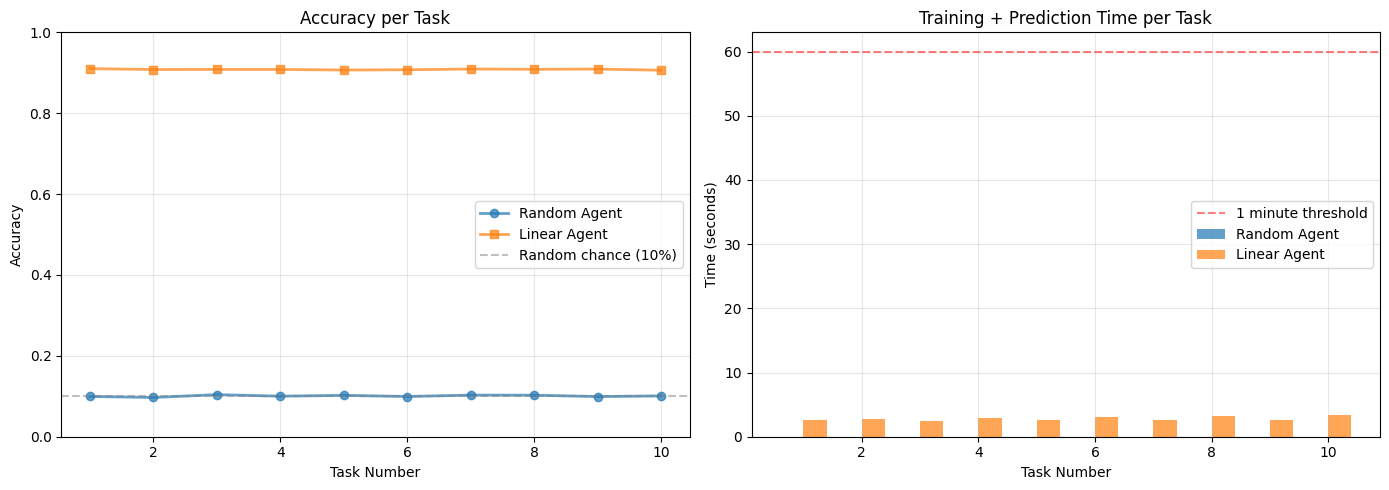

In [ ]:
# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
tasks = np.arange(1, len(random_accuracies) + 1)
ax1.plot(tasks, random_accuracies, 'o-', label='Random Agent', alpha=0.7, linewidth=2)
ax1.plot(tasks, linear_accuracies, 's-', label='Linear Agent', alpha=0.7, linewidth=2)
ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random chance (10%)')
ax1.set_xlabel('Task Number')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy per Task')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Time comparison
ax2.bar(tasks - 0.2, random_times, 0.4, label='Random Agent', alpha=0.7)
ax2.bar(tasks + 0.2, linear_times, 0.4, label='Linear Agent', alpha=0.7)
ax2.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='1 minute threshold')
ax2.set_xlabel('Task Number')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training + Prediction Time per Task')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Statistical Comparison

In [ ]:
# Create a summary comparison table
print("PERFORMANCE COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<25} {'Random Agent':<20} {'Linear Agent':<20}")
print("-"*70)

# Accuracy metrics
print(f"{'Mean Accuracy':<25} {np.mean(random_accuracies):<20.2%} {np.mean(linear_accuracies):<20.2%}")
print(f"{'Std Accuracy':<25} {np.std(random_accuracies):<20.2%} {np.std(linear_accuracies):<20.2%}")
print(f"{'Min Accuracy':<25} {np.min(random_accuracies):<20.2%} {np.min(linear_accuracies):<20.2%}")
print(f"{'Max Accuracy':<25} {np.max(random_accuracies):<20.2%} {np.max(linear_accuracies):<20.2%}")

print("-"*70)

# Time metrics
print(f"{'Mean Time per Task':<25} {np.mean(random_times):<20.4f}s {np.mean(linear_times):<20.2f}s")
print(f"{'Total Time':<25} {np.sum(random_times):<20.4f}s {np.sum(linear_times):<20.2f}s")

print("="*70)

# Performance analysis
improvement = (np.mean(linear_accuracies) - np.mean(random_accuracies)) / np.mean(random_accuracies)
print(f"\n📊 Linear agent shows {improvement:.1%} improvement over random baseline")

# Check if objective is met
max_time_random = np.max(random_times)
max_time_linear = np.max(linear_times)

print(f"\n⏱️  Time Constraint Check (< 1 minute per task):")
print(f"   Random Agent: {'✅ PASS' if max_time_random < 60 else '❌ FAIL'} (max: {max_time_random:.2f}s)")
print(f"   Linear Agent: {'✅ PASS' if max_time_linear < 60 else '❌ FAIL'} (max: {max_time_linear:.2f}s)")

PERFORMANCE COMPARISON SUMMARY
Metric                    Random Agent         Linear Agent        
----------------------------------------------------------------------
Mean Accuracy             10.08%               90.82%              
Std Accuracy              0.20%                0.11%               
Min Accuracy              9.70%                90.63%              
Max Accuracy              10.41%               91.02%              
----------------------------------------------------------------------
Mean Time per Task        0.0004              s 2.83                s
Total Time                0.0038              s 28.34               s

📊 Linear agent shows 800.7% improvement over random baseline

⏱️  Time Constraint Check (< 1 minute per task):
   Random Agent: ✅ PASS (max: 0.00s)
   Linear Agent: ✅ PASS (max: 3.43s)


## 9. Key Insights and Conclusions

### What we learned:

1. **Random Baseline**: The random agent achieves ~10% accuracy, which is expected for random guessing on 10 classes.

2. **Linear Agent Performance**: Despite the pixel and label permutations, the linear agent can learn patterns and achieve significantly better accuracy than random guessing.

3. **Time Efficiency**: Both agents meet the < 1 minute requirement, with the random agent being faster (no learning) and the linear agent still being very efficient.

4. **Meta-Learning Challenge**: Each task has different permutations, so the agent must learn from scratch each time. This tests the agent's ability to quickly adapt.

### Next Steps:

- Try implementing more sophisticated agents (e.g., neural networks with better architectures)
- Experiment with different hyperparameters (learning rate, epochs, batch size)
- Implement meta-learning algorithms that can leverage experience from previous tasks
- Add early stopping or adaptive learning rates for better performance

## 10. Experiment: Tuning the Linear Agent

Let's try different hyperparameters to see if we can improve performance:

In [ ]:
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
results = {}

for lr in learning_rates:
    # Reset environment
    env.reset()
    env.set_seed(42)

    # Create agent with different learning rate
    agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=lr)

    accuracies = []

    # Run through tasks
    while True:
        task = env.get_next_task()
        if task is None:
            break

        agent.reset()
        agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)
        predictions = agent.predict(task['X_test'])
        accuracy = env.evaluate(predictions, task['y_test'])
        accuracies.append(accuracy)

    results[lr] = np.mean(accuracies)
    print(f"Learning rate {lr}: Mean accuracy = {results[lr]:.2%}")

# Find best learning rate
best_lr = max(results, key=results.get)
print(f"\n🏆 Best learning rate: {best_lr} with {results[best_lr]:.2%} accuracy")

KeyboardInterrupt: 